# Notebook Overview
####This notebook is the apporoach taken by team QuasarX for the  **ITU-ML5G-PS-006: Intrusion and Vulnerability Detection in Software-Defined Networks (SDN)** challenge that ran from 2023-05-29 +03:00 to 2023-08-26 +03:00
#####The notebook is primarily focused on preprocessing and building the machine learning model. All other trials were removed for a clean running.
Its built on the GPU runtime on Google Colab T4
####**Notebook Runtime**: 50 Minutes (With GPU Runtime)

## Data Path
Data was accessed from Google drive, to reproduce this notebook, just consider the data paths in the setup section and the rest can be re-run.

####**Prepared by**: Ndabuye S. Gideon
####**Team**: QuasarX
####BSc. in Software Engineering, University of Dodoma, Tanzania


# Set Up

In [1]:
# replace with the path of the folder containing Train.csv and Test.csv files
path = '/content/drive/MyDrive/Challenges/ULAK/'

In [2]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from lightgbm import LGBMClassifier as LGB
from catboost import CatBoostClassifier as CAT
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
from sklearn.preprocessing import StandardScaler as SC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import HistGradientBoostingClassifier as HIST

In [4]:
# Display the full width of the DataFrame
# pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings('ignore')

In [5]:
# read the data, making sure the filenames match
train = pd.read_csv(path + 'Train.csv')
test = pd.read_csv(path + 'Test.csv')

train.shape, test.shape

((1783356, 79), (512077, 79))

# Preprocessing

In [6]:
train.head(2)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,68855579,10,6,1038,11595,346,0,103.8,167.133879,...,32,998.0,0.0,998,998,68300000.0,0.0,68300000,68300000,DoS Hulk
1,53,196,2,2,70,174,35,35,35.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
train['set'] = 'train'
test['set'] = 'test'

df = pd.concat([train, test]).reset_index(drop=True)
df.shape

(2295433, 80)

In [7]:
df['Fwd PSH Flags'].value_counts()

0    2188810
1     106623
Name: Fwd PSH Flags, dtype: int64

In [8]:
def plot_cols(df, str):
  flag_columns = df.filter(like=str).select_dtypes(include='number')

  num_columns = len(flag_columns.columns)
  num_rows = int((num_columns + 1) / 2)

  fig, axes = plt.subplots(2, num_rows, figsize=(12, 8), sharex=True)
  axes = axes.T

  for i, column in enumerate(flag_columns.columns):
      row_index = i // 2
      col_index = i % 2

      ax = axes[row_index, col_index]
      value_counts = flag_columns[column].value_counts().sort_index()

      ax.bar(value_counts.index, value_counts.values)
      ax.set_title(f'{column}')
      ax.set_xlabel('Value')
      ax.set_ylabel('Count')

  for i in range(num_columns, num_rows * 2):
      fig.delaxes(axes.flatten()[i])

  plt.tight_layout()
  plt.show()

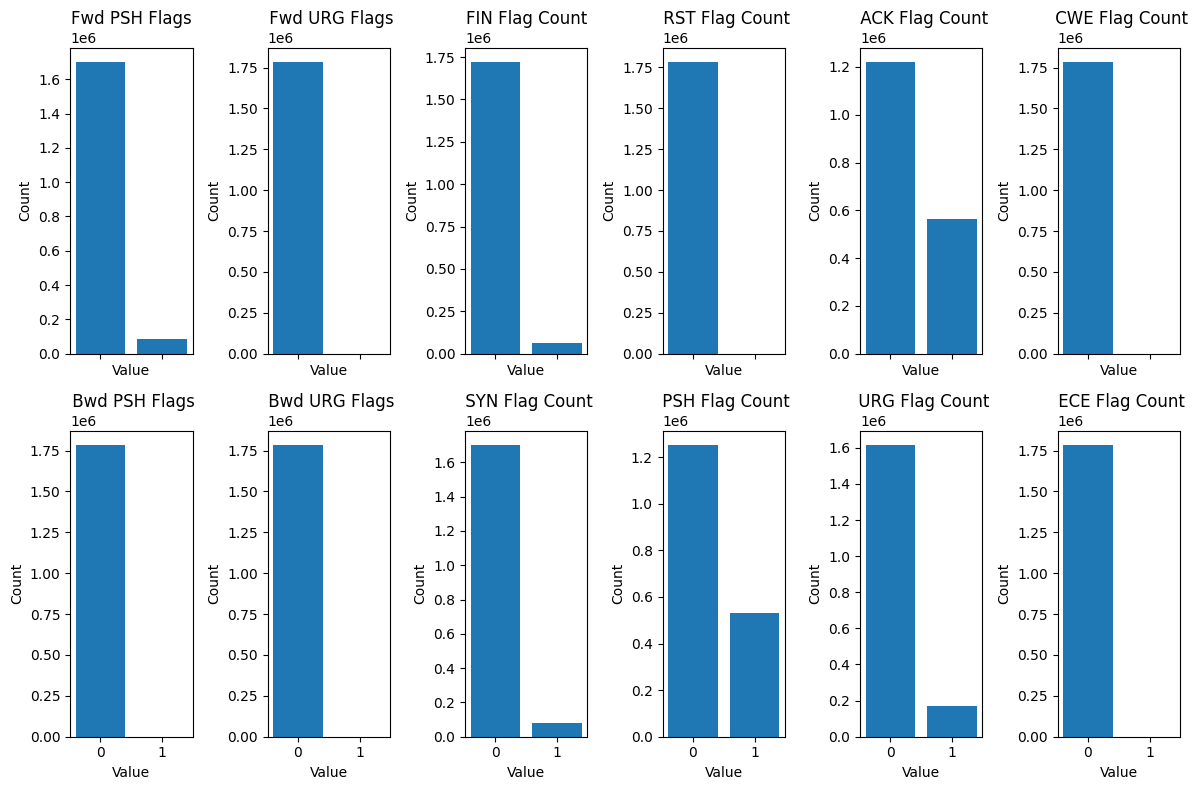

In [9]:
plot_cols(train, 'Flag')

In [10]:
train.isna().sum().sort_values(ascending=False)

Flow Bytes/s             859
 Destination Port          0
 Bwd Avg Packets/Bulk      0
 Fwd Avg Bulk Rate         0
 Fwd Avg Packets/Bulk      0
                        ... 
 Bwd IAT Mean              0
Bwd IAT Total              0
 Fwd IAT Min               0
 Fwd IAT Max               0
set                        0
Length: 80, dtype: int64

In [11]:
train.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,...,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06
mean,8.065165e+03,1.479300e+07,9.293318e+00,1.027692e+01,5.430794e+02,1.606083e+04,2.077775e+02,1.870418e+01,5.822551e+01,6.894169e+01,...,5.281908e+00,-2.231713e+03,8.149517e+04,4.108242e+04,1.529902e+05,5.823904e+04,8.323637e+06,5.070024e+05,8.705405e+06,7.925342e+06
std,1.827803e+04,3.365821e+07,7.232057e+02,9.559111e+02,5.842769e+03,2.218237e+06,7.174110e+02,6.027721e+01,1.861265e+02,2.806533e+02,...,6.017997e+02,9.334022e+05,6.485103e+05,3.883746e+05,1.021115e+06,5.787840e+05,2.364088e+07,4.623471e+06,2.438262e+07,2.337255e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.132300e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.236059e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553400e+04,1.200000e+08,2.177970e+05,2.895850e+05,1.827335e+06,6.396506e+08,2.482000e+04,2.325000e+03,5.675444e+03,7.125597e+03,...,2.074090e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [8]:
def preprocess(df):
  rem_cols = [a for a in df.columns if df[a].nunique()<=1] # columns with single unique value
  bin_cols = [c for c in df.columns if 'Flag' in c] # binary columns

  df.drop(columns=rem_cols, axis=1, inplace=True) # drop single unique value columns
  df.replace([np.inf, -np.inf], np.nan, inplace=True) # replace infinite values with high NaN
  scale_cols = df.columns.difference([' Label', 'set'] + bin_cols) # select columns to scale
  df = df.fillna(-999999) # fill NaN value with high negative number, to match the others

  sc = SC()
  df[scale_cols] = sc.fit_transform(df[scale_cols])   # scale clumns

  # split to train and test sets
  train = df[df['set']=='train'].drop(['set'], axis=1)
  test = df[df['set']=='test'].drop(['set'], axis=1)

  return train, test

In [9]:
rem = [' Label']

In [10]:
train, test = preprocess(df)

train.shape, test.shape

((1783356, 71), (512077, 71))

In [24]:
train.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,...,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06,1.783356e+06
mean,-1.178556e-04,2.055802e-04,-9.590178e-05,-1.126694e-04,-1.442122e-04,-6.943871e-05,-7.942223e-05,-4.745461e-04,-2.797009e-04,-1.595637e-04,...,-1.919480e-04,3.846523e-05,4.031907e-05,1.355413e-04,2.999570e-06,-1.055590e-04,2.798862e-04,1.239315e-04,2.845582e-04,2.663522e-04
std,9.999172e-01,1.000223e+00,9.716801e-01,9.682305e-01,9.476879e-01,9.807982e-01,1.000728e+00,9.960568e-01,9.995769e-01,9.989178e-01,...,9.569241e-01,9.657448e-01,9.965169e-01,9.980817e-01,9.977395e-01,9.944180e-01,1.000431e+00,1.001108e+00,1.000450e+00,1.000431e+00
min,-4.413305e-01,-4.393993e-01,-1.123859e-02,-1.052204e-02,-8.823085e-02,-7.170770e-03,-2.899117e-01,-3.095537e-01,-3.129750e-01,-2.455409e-01,...,-8.590732e-03,-5.554710e+02,-1.251872e-01,-1.054419e-01,-1.494849e-01,-1.001670e-01,-3.519586e-01,-1.096559e-01,-3.569092e-01,-3.389675e-01
25%,-4.384311e-01,-4.393943e-01,-9.895012e-03,-9.509148e-03,-8.628446e-02,-7.170770e-03,-2.815422e-01,-3.095537e-01,-2.807525e-01,-2.455409e-01,...,-8.590732e-03,2.368200e-03,-1.251872e-01,-1.054419e-01,-1.494849e-01,-1.001670e-01,-3.519586e-01,-1.096559e-01,-3.569092e-01,-3.389675e-01
50%,-4.369541e-01,-4.384681e-01,-9.895012e-03,-8.496260e-03,-7.817454e-02,-7.116385e-03,-2.382998e-01,-2.765045e-01,-1.303808e-01,-2.455409e-01,...,-7.000628e-03,2.372339e-03,-1.251872e-01,-1.054419e-01,-1.494849e-01,-1.001670e-01,-3.519586e-01,-1.096559e-01,-3.569092e-01,-3.389675e-01
75%,-4.170958e-01,-3.432327e-01,-5.864291e-03,-6.470485e-03,-5.789974e-02,-6.957652e-03,-1.769234e-01,2.853319e-01,-4.445410e-02,-1.524202e-01,...,-5.410524e-03,2.380616e-03,-1.251872e-01,-1.054419e-01,-1.494849e-01,-1.001670e-01,-3.519586e-01,-1.096559e-01,-3.569092e-01,-3.389675e-01
max,3.143771e+00,3.126650e+00,2.926137e+02,2.933066e+02,2.963026e+02,2.828157e+02,3.433191e+01,3.811014e+01,3.016653e+01,2.511631e+01,...,3.297933e+02,2.490289e-03,1.689035e+02,1.905807e+02,1.073324e+02,1.888926e+02,4.726185e+00,1.654129e+01,4.566843e+00,4.797475e+00


In [11]:
X = train.drop(rem, axis=1)
y = train[' Label']

X.shape

(1783356, 70)

# Modelling

In [12]:
model = CAT(
              learning_rate=0.1,
              depth=12,
              iterations=1500,
              eval_metric='Accuracy',
              use_best_model =True,
              verbose=100,
              random_seed= 0,
              task_type='GPU'
              )

In [13]:
from sklearn.model_selection import StratifiedKFold as SKF
from catboost import CatBoostClassifier, Pool

SEED=0
main_cols = X.columns.tolist()

score = 0
skf = SKF(n_splits=5, shuffle=True, random_state=SEED)
# oof_cat = np.zeros((X.shape[0],))
oof_cat = np.empty(X.shape[0], dtype=object)
cat_preds= []
for fold_, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print('Fold:',fold_+1)

    # Creating train/valid data
    X_train, y_train = X.iloc[trn_idx,:], y[trn_idx]
    X_test, y_test = X.iloc[val_idx,:], y[val_idx]

    model.fit(
                  Pool(X_train,y_train,),
                  eval_set = Pool(X_test, y_test,),
                  early_stopping_rounds=500
                  )

    y_pred_val = model.predict(X_test)
    oof_cat[val_idx] = y_pred_val.flatten()
    score = score + acc(y_test, y_pred_val)
    y_pred_test = model.predict(test[main_cols])
    cat_preds.append(y_pred_test)

print('CatBoost OOF Accuracy Score :', acc(y, oof_cat))

Fold: 1
0:	learn: 0.9933349	test: 0.9932992	best: 0.9932992 (0)	total: 482ms	remaining: 12m 3s
100:	learn: 0.9988035	test: 0.9988533	best: 0.9988589 (99)	total: 36.2s	remaining: 8m 21s
200:	learn: 0.9989654	test: 0.9989570	best: 0.9989570 (200)	total: 1m 10s	remaining: 7m 33s
300:	learn: 0.9990418	test: 0.9989710	best: 0.9989823 (233)	total: 1m 46s	remaining: 7m 3s
400:	learn: 0.9990881	test: 0.9989963	best: 0.9989963 (399)	total: 2m 23s	remaining: 6m 33s
500:	learn: 0.9991098	test: 0.9989879	best: 0.9989991 (468)	total: 2m 59s	remaining: 5m 57s
600:	learn: 0.9991252	test: 0.9989823	best: 0.9989991 (468)	total: 3m 34s	remaining: 5m 20s
700:	learn: 0.9991393	test: 0.9989823	best: 0.9989991 (468)	total: 4m 10s	remaining: 4m 45s
800:	learn: 0.9991638	test: 0.9990047	best: 0.9990103 (778)	total: 4m 44s	remaining: 4m 8s
900:	learn: 0.9991771	test: 0.9989991	best: 0.9990103 (778)	total: 5m 20s	remaining: 3m 33s
1000:	learn: 0.9991848	test: 0.9989991	best: 0.9990103 (778)	total: 5m 56s	remain

# Evaluation

In [14]:
x_test = test.drop(rem, axis=1)
preds = model.predict(x_test)

print(f'Accuracy: {acc(test[" Label"], preds)}')

Accuracy: 0.9989864805488237


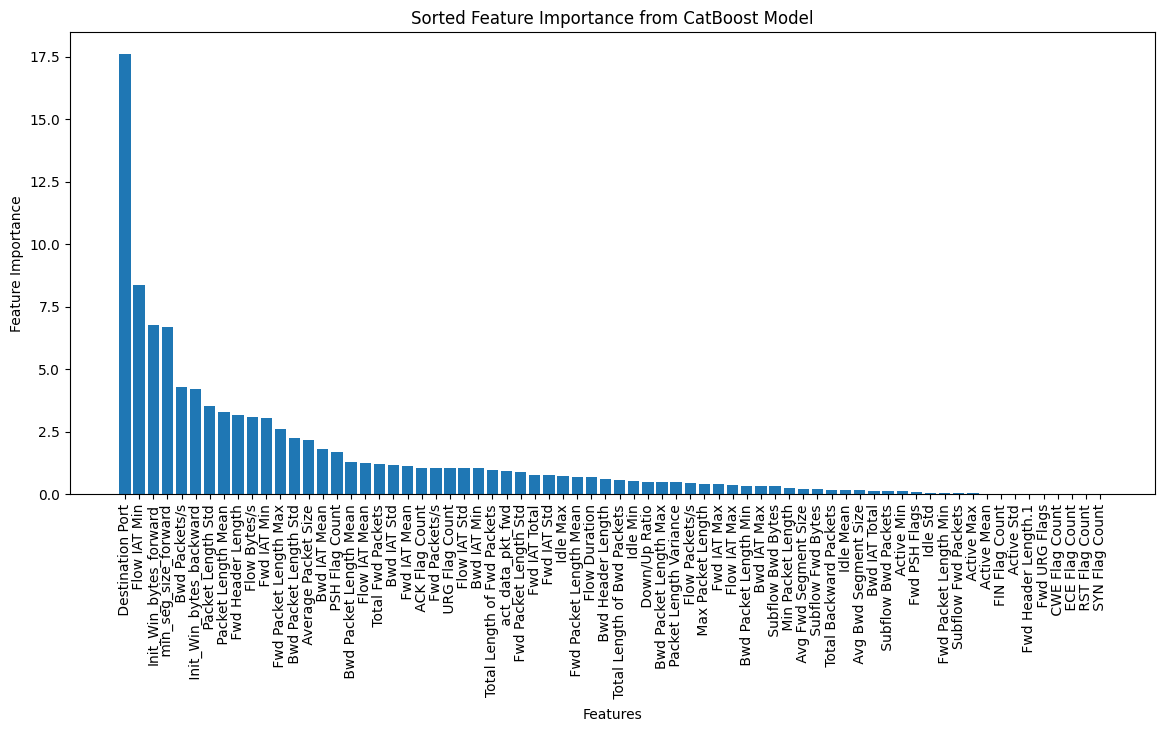

In [33]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_


# Create a DataFrame to hold feature names and their importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot of sorted feature importances
plt.figure(figsize=(14, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Sorted Feature Importance from CatBoost Model')
plt.show()

In [ ]:
cmatrix = cm(test[" Label"], preds)

In [20]:
# Calculate proportions instead of numbers in the confusion matrix
cmatrix = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]

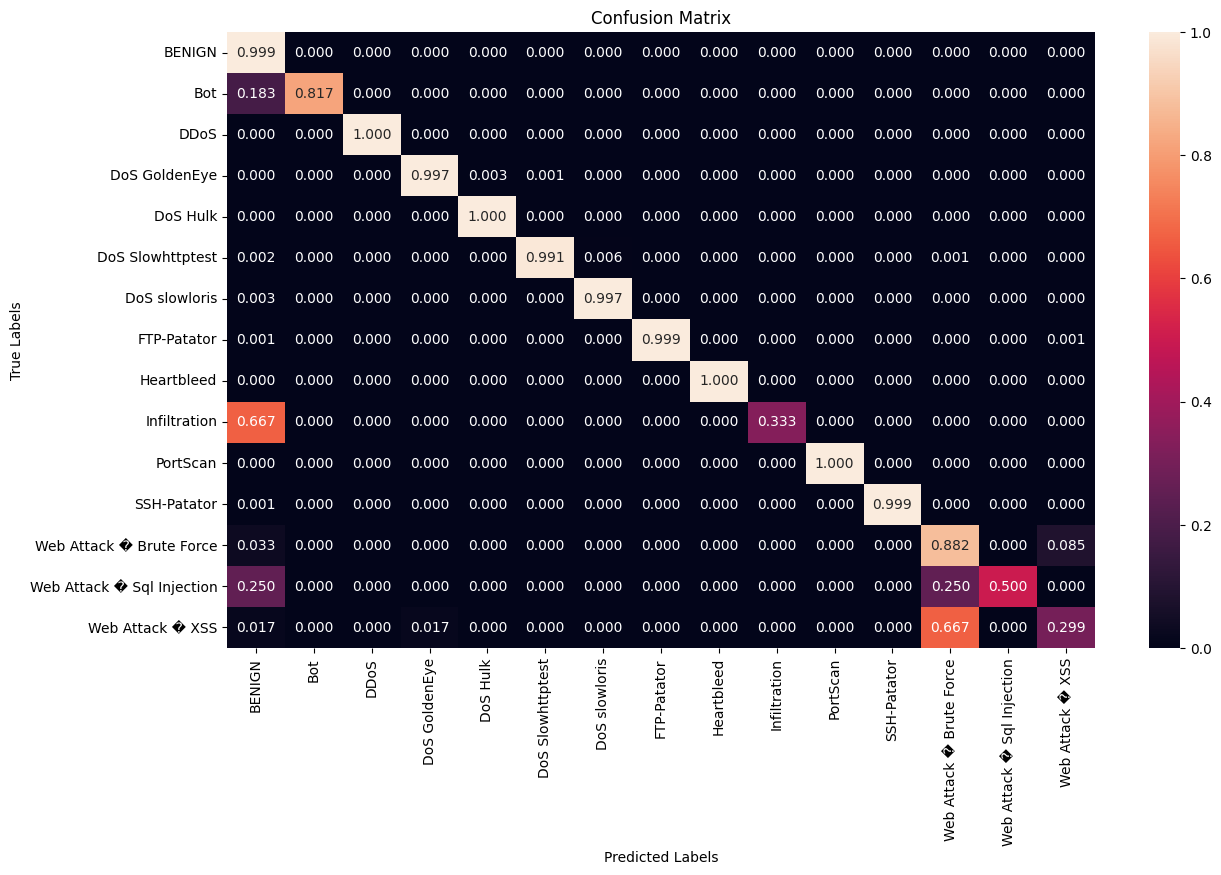

In [23]:
# Display confusion matrix using seaborn and matplotlib
plt.figure(figsize=(14, 8))
sns.heatmap(cmatrix, annot=True, fmt='.3f', xticklabels=np.unique(test[' Label'].unique()), yticklabels=np.unique(preds))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
classreport = cr(test[" Label"], preds)

report_data = []
lines = classreport.split('\n')
for line in lines[2:-5]:
    row = line.split()
    row_data = {'Class': ' '.join(row[:-4]),
                'Precision': float(row[-4]),
                'Recall': float(row[-3]),
                'F1-Score': float(row[-2]),
                'Support': int(row[-1])}
    report_data.append(row_data)

report_df = pd.DataFrame(report_data)

report_df

,Class,Precision,Recall,F1-Score,Support
0,BENIGN,1.00,1.00,1.00,411203
1,Bot,0.87,0.81,0.84,355
2,DDoS,1.00,1.00,1.00,23160
3,DoS GoldenEye,1.00,1.00,1.00,1861
4,DoS Hulk,1.00,1.00,1.00,41801
5,DoS Slowhttptest,0.99,0.99,0.99,994
6,DoS slowloris,0.99,1.00,1.00,1048
7,FTP-Patator,1.00,1.00,1.00,1436
8,Heartbleed,1.00,1.00,1.00,2
9,Infiltration,1.00,0.33,0.50,6


# Saving Model Weights

In [ ]:
model_filename = 'catboost_model.pkl'

# Save the model to a file using pickle
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
import pickle

# Specify the file path where the trained model is saved
model_filename = 'catboost_model.pkl'

# Load the model from the file using pickle
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Use the loaded model to make predictions on the test test
predictions = loaded_model.predict(x_test)